<div style="font-family: Arial; text-align: center;">

## KMeans Clustering
#### Kannan Singaravelu, CQF

##  Clustering

Clustering is a branch of unsupervised machine learning models that seeks to learn from the properties of the data by identifying groups or clusters in the dataset. Clustering is different from classification as it seeks to identify a set of similar data points and calling the resulting set a cluster. Selecting an appropriate clustering algorithm is often difficult due to the number of choices available. For a comprehensive survey of clustering algorithms, refer [here](https://urldefense.com/v3/__https://link.springer.com/content/pdf/10.1007/s40745-015-0040-1.pdf__;!!KGvANbslH1YjwA!7pvCDr14M9vz2HZfCMivIxmMPr4K7K8mS-jKcfnsmpn3k3wHDFNOWiWv6dCTQP9GZ8EO00s-sRPZ2pap9yofGCjQd27iiqzYE8Y$). The three most popular categories of clustering algorithms are

| Categories               | Clustering Algorithm                                           |
|--------------------------|----------------------------------------------------------------|
| Partitional clustering   | Divides data objects into non overlapping groups               |
| Hierarchical clustering  | Assignments by building a hierarchy                            |
| Density-based clustering | Assignments based on the density of data points in a region   |


##  K-Means Algorithm

The $k$-means algorithm searches for a predetermined number of clusters within an unlabeled dataset and is based on the assumptions that the optimal cluster will have
* “cluster center” which is the mean of all the points belonging to the cluster.
* each point is closer to its own cluster center than to other cluster centers.

Conventional $k$-means algorithm requires only a few steps and follows a two-step process called **Expectation-Maximization** approach. This consists of
1. Randomly selecting $k$-centroids or cluster center
2. Repeat until converged
* 2a. E-Step: assign points to the nearest cluster center
* 2b. M-Step: set the cluster center to the mean

The "E-Step" or "Expectation Step" assigns each data point to its nearest centroid. Then, the "M-Step" or Maximization Step" computes the mean of all the points for each cluster and sets the new centroid. The $k$-means algorithms seeks to find $k$ clusters within a data set. The clusters are chosen to reduce the **inertia**, the objective function
$$
\min_{C_k} \sum_{k} \sum_{X_j \in C_k} \| X_j - \mu_k \|^2
$$
and the centroid of a cluster $\mu_k$ is equal to
$$
\mu_k = \frac{1}{|C_k|} \sum_{X_j \in C_k} X_j,
$$
where $|C_k|$ is the number of points in cluster $k$.

The cluster assignments are done based on squared Euclidean distance and algorithm tries to minimize the objective function. This process is repeated, iteratively, until the sum of the distance is minimized.

## Implementation


In [3]:
# !pip install pandas_ta

In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Base Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta

# Plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
plt.style.use('fivethirtyeight')

# Set display options
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

# set seed
np.random.seed(2024)

## Load the Dataset


In [14]:
# Run the below code to retrieve data for the first time

# Read components of dow from Yahoo Finance
dow = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')

# Retrieve components table
dow[1]

# Retrieve stock symbol
dow_stocks = sorted(list(dow[1]['Symbol']))
dow_company_name = list(dow[1]['Company'])
dow_stocks[:5]

['AAPL', 'AMGN', 'AMZN', 'AXP', 'BA']

In [51]:
# Use comprehension to fetch data for multiple fields 
dow_ohlc = {symbol: yf.download(symbol, start='2013-01-01', end='2023-12-31', auto_adjust=True, progress=False) for symbol in dow_stocks}

# # Save dow_ohlc dict for future use
np.save('../Python Labs/JAP12_JA24_K-Means_Clustering_dow_ohlc.npy', dow_ohlc)

# Load down_ohlc dict 
ohlc = np.load('../Python Labs/JAP12_JA24_K-Means_Clustering_dow_ohlc.npy', allow_pickle='TRUE').item()
ohlc.keys()

dict_keys(['AAPL', 'AMGN', 'AMZN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WMT'])

In [16]:
# get the stock tickers
dow_stocks = sorted(list(ohlc.keys()))
dow_stocks[:5]

['AAPL', 'AMGN', 'AMZN', 'AXP', 'BA']

In [17]:
# subsume into dataframe
df = pd.DataFrame({symbol: ohlc[symbol]['Close'] for symbol in dow_stocks})
df.head(3)

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,GS,HD,HON,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,16.725042,65.534416,12.8655,50.010674,64.583878,68.871971,42.736675,14.324562,68.787292,46.303730,NaN,106.419838,48.745586,48.691570,118.749153,15.386281,51.558197,32.691399,26.398109,66.191986,50.800457,27.764898,22.492281,22.732588,49.835758,56.239162,45.892818,35.808281,25.332684,18.082636
2013-01-03,16.513926,65.122704,12.9240,50.223480,64.919044,69.534920,42.122478,14.402027,68.494423,46.403412,NaN,105.837852,48.607357,48.879562,118.095985,15.343106,51.485420,32.625542,26.398109,66.566582,50.741501,28.429800,22.190973,22.965004,49.519741,56.671432,43.747116,35.835934,25.212509,17.967730
2013-01-04,16.053940,65.409409,12.9575,50.742764,65.103394,69.917953,42.347183,14.423153,68.855835,47.291424,NaN,108.723473,48.515221,49.879715,117.321846,15.227962,52.074955,33.203815,26.440237,65.993660,51.116680,28.188007,21.775652,23.188637,49.620293,57.165421,43.831261,36.128613,25.349852,18.035631


In [18]:
# verify the shape
df.shape

(2768, 30)

## Perform EDA

In [20]:
# perform EDA
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AAPL,2768.0,70.214481,56.746122,11.966003,25.117517,41.807346,127.321442,197.589523
AMGN,2768.0,161.153070,54.041214,60.337200,120.768791,152.932777,210.529083,284.203918
AMZN,2768.0,78.078527,52.929354,12.411500,26.680125,80.149502,120.954998,186.570496
AXP,2768.0,100.981980,38.214496,45.193371,70.094103,89.873028,136.081932,192.251404
BA,2768.0,194.555096,87.704894,61.717930,121.064455,174.816498,239.225002,430.299957
CAT,2768.0,125.142372,61.560193,46.943859,69.931408,113.368107,177.173378,295.667419
CRM,2768.0,132.060826,68.459924,36.702057,71.494110,130.339745,185.277977,309.555634
CSCO,2768.0,33.368232,12.550746,14.289347,21.241046,35.693909,44.283504,59.220711
CVX,2768.0,93.665017,29.321703,44.864262,74.675152,84.651703,97.352844,176.953262
DIS,2768.0,106.483973,31.291157,45.832539,88.768761,100.858433,116.958822,201.254089


## Check Missing Values

In [21]:
# Check for missing values
df.isnull().sum()

AAPL       0
AMGN       0
AMZN       0
AXP        0
BA         0
CAT        0
CRM        0
CSCO       0
CVX        0
DIS        0
DOW     1563
GS         0
HD         0
HON        0
IBM        0
INTC       0
JNJ        0
JPM        0
KO         0
MCD        0
MMM        0
MRK        0
MSFT       0
NKE        0
PG         0
TRV        0
UNH        0
V          0
VZ         0
WMT        0
dtype: int64

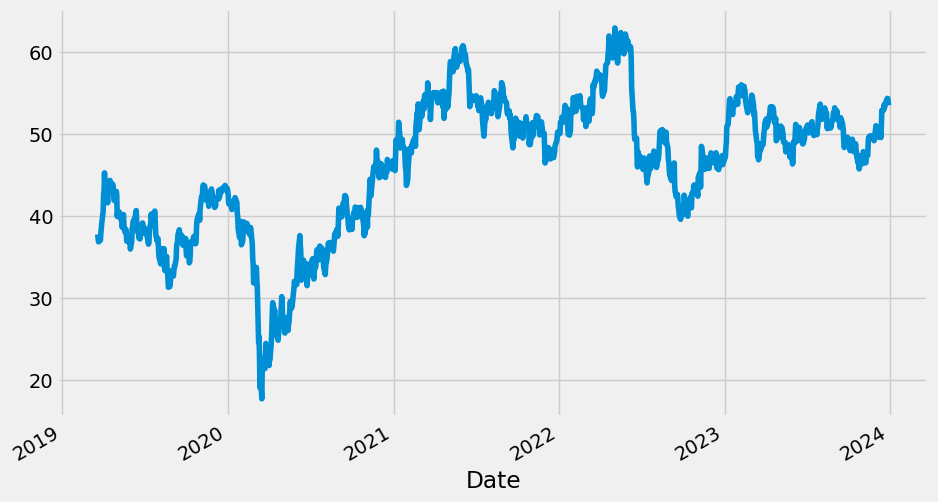

In [27]:
# plot dow close prices
ohlc['DOW']['Close'].plot();  # semicolon to suppress "<Axes: xlabel='Date'>"

In [28]:
# Get the index of the NaN values
[df[x].index[df[x].apply(np.isnan)] for x in dow_stocks]

[DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None),
 DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-14', '2013-01-15',
                ...
                '2019-03-06', '2019-03-07', '2019-03-08', '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15', '2019-03-18', '2

## Impute Missing Values


In [29]:
# Fill forward the missing values and drop DOW from the list
df.fillna(method='ffill', axis=0, inplace=True)
df.drop(['DOW'], axis=1, inplace=True)
df.dropna(inplace=True)

In [30]:
# Verify whether missing values are dropped
np.isnan(df.any()).sum()

0

In [31]:
# remove dow chemicals from the stock list
dow_stocks.remove('DOW')

## Add ATR Feature

In [32]:
# add ATR features
newdict = {}
for symbol in dow_stocks:
    data = ohlc[symbol]
    data.dropna(inplace=True)
    # data.fillna(method='ffill', axis=0, inplace=True)
    
    high = data['High']
    low = data['Low']
    close = data['Close']
    data['ATR'] = ta.atr(high,low,close)
    data.dropna(inplace=True)
    
    newdict.update({symbol: data})

In [33]:
# subsume into a dataframe
df2 = pd.DataFrame({symbol: newdict[symbol]['ATR'] for symbol in dow_stocks})
df2 = df2.resample('W-FRI').mean()
df2 = df2.T
df2.head()

Date,2013-01-25,2013-02-01,2013-02-08,2013-02-15,2013-02-22,2013-03-01,2013-03-08,2013-03-15,2013-03-22,2013-03-29,2013-04-05,2013-04-12,2013-04-19,2013-04-26,2013-05-03,2013-05-10,2013-05-17,2013-05-24,2013-05-31,2013-06-07,2013-06-14,2013-06-21,2013-06-28,2013-07-05,2013-07-12,2013-07-19,2013-07-26,2013-08-02,2013-08-09,2013-08-16,2013-08-23,2013-08-30,2013-09-06,2013-09-13,2013-09-20,2013-09-27,2013-10-04,2013-10-11,2013-10-18,2013-10-25,2013-11-01,2013-11-08,2013-11-15,2013-11-22,2013-11-29,2013-12-06,2013-12-13,2013-12-20,2013-12-27,2014-01-03,2014-01-10,2014-01-17,2014-01-24,2014-01-31,2014-02-07,2014-02-14,2014-02-21,2014-02-28,2014-03-07,2014-03-14,2014-03-21,2014-03-28,2014-04-04,2014-04-11,2014-04-18,2014-04-25,2014-05-02,2014-05-09,2014-05-16,2014-05-23,2014-05-30,2014-06-06,2014-06-13,2014-06-20,2014-06-27,2014-07-04,2014-07-11,2014-07-18,2014-07-25,2014-08-01,2014-08-08,2014-08-15,2014-08-22,2014-08-29,2014-09-05,2014-09-12,2014-09-19,2014-09-26,2014-10-03,2014-10-10,2014-10-17,2014-10-24,2014-10-31,2014-11-07,2014-11-14,2014-11-21,2014-11-28,2014-12-05,2014-12-12,2014-12-19,2014-12-26,2015-01-02,2015-01-09,2015-01-16,2015-01-23,2015-01-30,2015-02-06,2015-02-13,2015-02-20,2015-02-27,2015-03-06,2015-03-13,2015-03-20,2015-03-27,2015-04-03,2015-04-10,2015-04-17,2015-04-24,2015-05-01,2015-05-08,2015-05-15,2015-05-22,2015-05-29,2015-06-05,2015-06-12,2015-06-19,2015-06-26,2015-07-03,2015-07-10,2015-07-17,2015-07-24,2015-07-31,2015-08-07,2015-08-14,2015-08-21,2015-08-28,2015-09-04,2015-09-11,2015-09-18,2015-09-25,2015-10-02,2015-10-09,2015-10-16,2015-10-23,2015-10-30,2015-11-06,2015-11-13,2015-11-20,2015-11-27,2015-12-04,2015-12-11,2015-12-18,2015-12-25,2016-01-01,2016-01-08,2016-01-15,2016-01-22,2016-01-29,2016-02-05,2016-02-12,2016-02-19,2016-02-26,2016-03-04,2016-03-11,2016-03-18,2016-03-25,2016-04-01,2016-04-08,2016-04-15,2016-04-22,2016-04-29,2016-05-06,2016-05-13,2016-05-20,2016-05-27,2016-06-03,2016-06-10,2016-06-17,2016-06-24,2016-07-01,2016-07-08,2016-07-15,2016-07-22,2016-07-29,2016-08-05,2016-08-12,2016-08-19,2016-08-26,2016-09-02,2016-09-09,2016-09-16,2016-09-23,2016-09-30,2016-10-07,2016-10-14,2016-10-21,2016-10-28,2016-11-04,2016-11-11,2016-11-18,2016-11-25,2016-12-02,2016-12-09,2016-12-16,2016-12-23,2016-12-30,2017-01-06,2017-01-13,2017-01-20,2017-01-27,2017-02-03,2017-02-10,2017-02-17,2017-02-24,2017-03-03,2017-03-10,2017-03-17,2017-03-24,2017-03-31,2017-04-07,2017-04-14,2017-04-21,2017-04-28,2017-05-05,2017-05-12,2017-05-19,2017-05-26,2017-06-02,2017-06-09,2017-06-16,2017-06-23,2017-06-30,2017-07-07,2017-07-14,2017-07-21,2017-07-28,2017-08-04,2017-08-11,2017-08-18,2017-08-25,2017-09-01,2017-09-08,2017-09-15,2017-09-22,2017-09-29,2017-10-06,2017-10-13,2017-10-20,2017-10-27,2017-11-03,2017-11-10,2017-11-17,2017-11-24,2017-12-01,2017-12-08,2017-12-15,2017-12-22,2017-12-29,2018-01-05,2018-01-12,2018-01-19,2018-01-26,2018-02-02,2018-02-09,2018-02-16,2018-02-23,2018-03-02,2018-03-09,2018-03-16,2018-03-23,2018-03-30,2018-04-06,2018-04-13,2018-04-20,2018-04-27,2018-05-04,2018-05-11,2018-05-18,2018-05-25,2018-06-01,2018-06-08,2018-06-15,2018-06-22,2018-06-29,2018-07-06,2018-07-13,2018-07-20,2018-07-27,2018-08-03,2018-08-10,2018-08-17,2018-08-24,2018-08-31,2018-09-07,2018-09-14,2018-09-21,2018-09-28,2018-10-05,2018-10-12,2018-10-19,2018-10-26,2018-11-02,2018-11-09,2018-11-16,2018-11-23,2018-11-30,2018-12-07,2018-12-14,2018-12-21,2018-12-28,2019-01-04,2019-01-11,2019-01-18,2019-01-25,2019-02-01,2019-02-08,2019-02-15,2019-02-22,2019-03-01,2019-03-08,2019-03-15,2019-03-22,2019-03-29,2019-04-05,2019-04-12,2019-04-19,2019-04-26,2019-05-03,2019-05-10,2019-05-17,2019-05-24,2019-05-31,2019-06-07,2019-06-14,2019-06-21,2019-06-28,2019-07-05,2019-07-12,2019-07-19,2019-07-26,2019-08-02,2019-08-09,2019-08-16,2019-08-23,2019-08-30,2019-09-06,2019-09-13,2019-09-20,2019-09-27,2019-10-04,2019-10-11,2019-10-18,2019-10-25,2019-11-01,2019-11-08,2019-11-15,2019-11-22,2019-11-29,2019-12-06,2019-12-13,2019-12-20,2019-12-27,2020-01-03,20

In [34]:
# get the dimension
df2 .shape

(29, 571)

In [35]:
# verify whether missing values are dropped 
np.isnan(df2.any()).sum()

0

In [36]:
# summary statistics
df2.T.describe()

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,HD,HON,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
count,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000,571.000000
mean,1.636321,3.442080,2.090958,2.223356,5.286800,3.006055,3.668456,0.656320,1.985688,2.228464,4.749210,3.505371,2.339760,1.871184,0.869435,1.709058,1.812916,0.600267,2.360121,1.810269,1.091922,2.961592,1.721018,1.409139,2.015401,5.045566,2.656698,0.597424,0.517323
std,1.503452,1.452656,1.724047,1.491287,3.519349,1.838743,2.402287,0.345375,1.100738,1.241920,2.366842,2.581071,1.455431,0.590587,0.503482,0.843534,1.095077,0.316633,1.518777,0.798022,0.544475,2.668899,1.148705,0.846060,1.094713,3.781748,1.914544,0.217803,0.288006
min,0.220579,1.033052,0.256742,0.698910,0.976437,0.789543,0.840701,0.208164,0.749797,0.649929,1.677868,0.599065,0.568588,0.890195,0.227182,0.400917,0.508888,0.245799,0.626870,0.534179,0.372196,0.280494,0.313441,0.438433,0.634637,0.702870,0.491496,0.308956,0.171207
25%,0.445277,2.301497,0.551479,1.042749,2.186829,1.315220,1.574576,0.346076,1.127118,1.273115,2.897476,1.427081,1.143511,1.472315,0.457014,0.992431,0.901084,0.372908,1.147471,1.132108,0.650370,0.761046,0.785795,0.783553,1.104550,1.874466,1.032197,0.454613,0.282360
50%,0.829198,3.250345,1.492211,1.528765,5.139108,2.434832,3.051264,0.655367,1.666220,1.845312,3.754995,2.613504,1.912062,1.796666,0.863078,1.578585,1.520800,0.509842,2.046272,1.806016,0.933255,1.667656,1.332651,1.072943,1.665125,4.209945,2.070243,0.558584,0.429716
75%,2.855823,4.350080,3.429480,3.235279,7.410126,4.628870,5.347789,0.881560,2.409457,2.966433,6.598385,5.148573,3.335535,2.117589,1.127171,2.254749,2.560428,0.734201,3.314335,2.283333,1.439671,5.186676,2.615675,1.899770,2.798827,7.657297,3.937262,0.697905,0.695139
max,5.816831,11.081765,6.723604,8.417004,22.202176,7.028483,12.103089,2.364141,5.643861,8.093271,12.288839,14.357670,10.377433,5.628698,3.727685,6.353765,7.247046,2.645598,11.947917,5.981508,3.459113,10.060617,6.226125,6.387341,7.309776,19.925052,11.715436,2.191683,2.075464


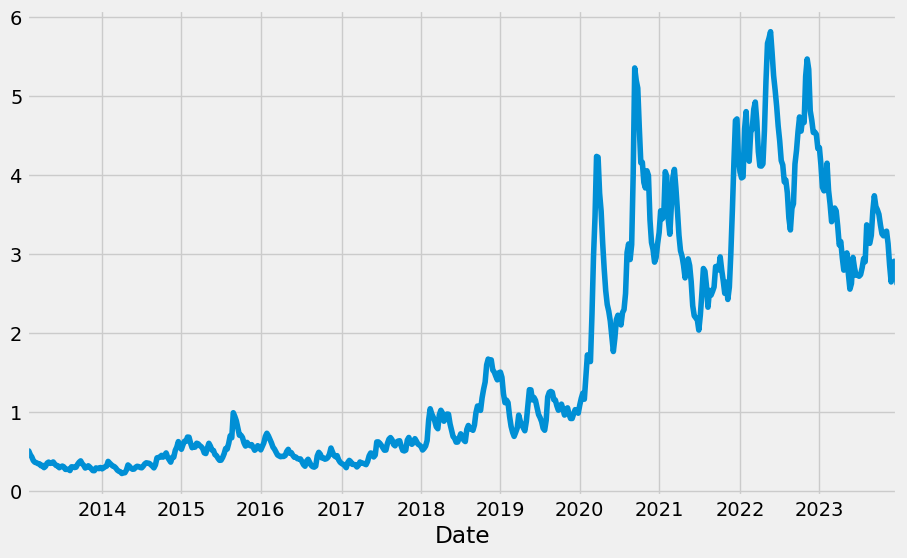

In [37]:
# Plot weekly atr values for AAPL
df2.loc['AAPL'].plot();

## Elbow Plot

The number of clusters is a hyperparameter to clustering models and choose the optimal number of clusters is critical for the model. If every point is its own cluster, the inertia is zero and hence choosing the number of clusters that yields the lowest results in not appropriate. Instead, we need to identify the inflection point where increasing the number of clusters no longer result in significant drop in inertia. Elbow plot helps us to select the optimal number of clusters.

In [38]:
# Import sklearn modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# import yfinance as yf
from datetime import datetime

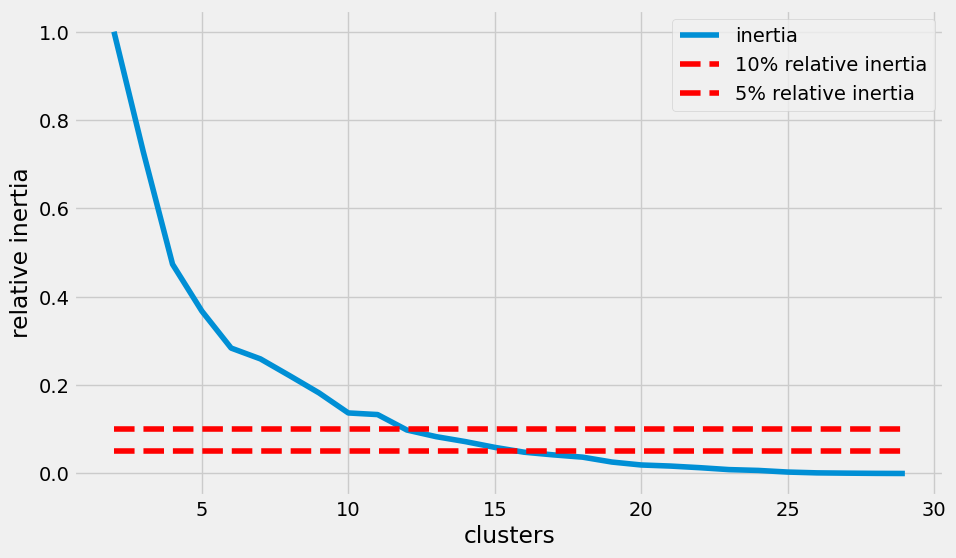

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

_clusters = range(2, 30)
inertia = []

try:
    for n in _clusters:
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(df2)
        inertia.append(kmeans.inertia_)
except ValueError as e:
    print(f"An error occurred: {e}")
    # Handle specific environment issues or fallback if necessary

plt.plot(_clusters, np.divide(inertia, inertia[0]))
plt.hlines(0.1, _clusters[0], _clusters[-1], 'r', linestyles='dashed')
plt.hlines(0.05, _clusters[0], _clusters[-1], 'r', linestyles='dashed')
plt.xlabel('clusters')
plt.ylabel('relative inertia')
plt.legend(['inertia', '10% relative inertia', '5% relative inertia'])
plt.show()

Silhouette Coefficient is another metric measure of how dense and separated are the clusters. Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters. Silhouette coefficient implementation is straight forward where the average silhouette coefficient of all the samples is summarized into one score. The silhouette_score function needs a minimum of two clusters, or it will raise an exception.

## Build Clusters

We will now fit the cluster model. Given the timeseries characteristics, the dataset needs to be normalized for the model to work properly. The normalizing can be accomplished by using the Normalizer transformer from Scikit-Learn


In [40]:
# Normalize and fit the model
model = Pipeline([
    ("normalization", MinMaxScaler()), 
    ("cluster", KMeans(n_clusters=15))
    ])

In [41]:
# Fit Model
model.fit(df2) 

# Assign Label
labels = model.predict(df2)

In [42]:
# Check lables
labels

array([12,  7, 12,  1,  4, 10,  2,  0, 14,  1,  3, 11,  1,  9,  0,  6,  6,
        0,  1,  6, 13,  8,  6, 13,  1,  5,  1,  0,  0])

In [43]:
# Create dataframe to hold cluster details
df3 = pd.DataFrame({'Cluster': labels, 
                    'Companies': dow_stocks,
                    'ATR': df2.mean(axis=1)}
                  ).sort_values(by=['Cluster'], axis = 0)

df3 = df3.reset_index(drop=True)
df3

,Cluster,Companies,ATR
0,0,INTC,0.869435
1,0,KO,0.600267
2,0,VZ,0.597424
3,0,CSCO,0.656320
4,0,WMT,0.517323
5,1,AXP,2.223356
6,1,V,2.656698
7,1,DIS,2.228464
8,1,HON,2.339760
9,1,TRV,2.015401


Thus, using k-means, we have discovered companies that exhibit similar volatility characteristics as measured by the Average True Range (ATR).


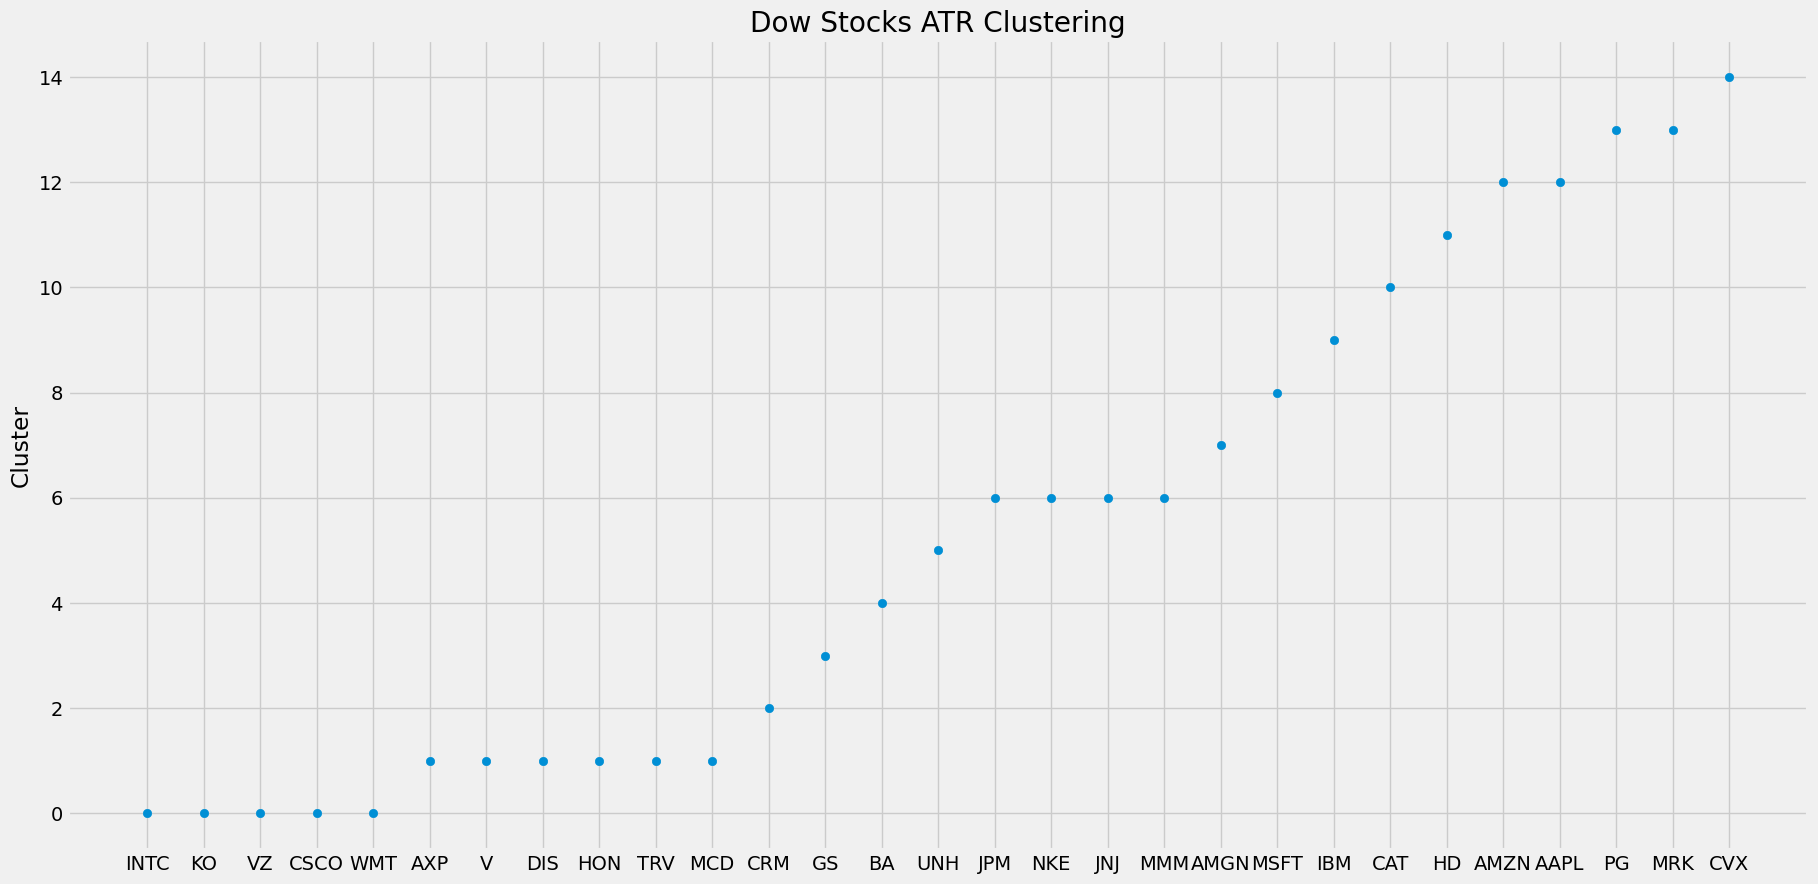

In [44]:
plt.figure(figsize=(20,10))
plt.scatter(df3.Companies, df3.Cluster)
# plt.xlabel('Stocks')
plt.ylabel('Cluster')
plt.title('Dow Stocks ATR Clustering');

In [45]:
model.get_params()

{'memory': None,
 'steps': [('normalization', MinMaxScaler()),
  ('cluster', KMeans(n_clusters=15))],
 'verbose': False,
 'normalization': MinMaxScaler(),
 'cluster': KMeans(n_clusters=15),
 'normalization__clip': False,
 'normalization__copy': True,
 'normalization__feature_range': (0, 1),
 'cluster__algorithm': 'lloyd',
 'cluster__copy_x': True,
 'cluster__init': 'k-means++',
 'cluster__max_iter': 300,
 'cluster__n_clusters': 15,
 'cluster__n_init': 'auto',
 'cluster__random_state': None,
 'cluster__tol': 0.0001,
 'cluster__verbose': 0}

In [46]:
model['cluster'].cluster_centers_

array([[0.05268504, 0.04430931, 0.03363012, ..., 0.02893328, 0.03174744,
        0.03759587],
       [0.2666923 , 0.27086997, 0.27684935, ..., 0.27900345, 0.2847964 ,
        0.30271271],
       [0.4114488 , 0.46403785, 0.40487861, ..., 0.6157434 , 0.6073938 ,
        0.61065618],
       ...,
       [0.10264812, 0.14639424, 0.12178228, ..., 0.31559124, 0.30934698,
        0.31882587],
       [0.12498433, 0.18031111, 0.18417693, ..., 0.15817933, 0.16890446,
        0.17429678],
       [0.31870109, 0.3406714 , 0.35316483, ..., 0.26918141, 0.26984848,
        0.28504788]])

In [47]:
model['cluster'].cluster_centers_.shape

(15, 571)

In [50]:
# Save locally to be used in SOM
df3.to_csv('../Python Labs/JAP12_JA24_K-Means_Clustering_cluster_new_2024.csv')

##  References

* [KMeans](https://urldefense.com/v3/__https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html__;!!KGvANbslH1YjwA!7pvCDr14M9vz2HZfCMivIxmMPr4K7K8mS-jKcfnsmpn3k3wHDFNOWiWv6dCTQP9GZ8EO00s-sRPZ2pap9yofGCjQd27iOWi-1TU$)

* [Silhouette Score](https://urldefense.com/v3/__https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html__;!!KGvANbslH1YjwA!7pvCDr14M9vz2HZfCMivIxmMPr4K7K8mS-jKcfnsmpn3k3wHDFNOWiWv6dCTQP9GZ8EO00s-sRPZ2pap9yofGCjQd27iThlDF1g$)

* [Python Resources](https://github.com/kannansingaravelu/PythonResources)

Python Labs by [Kannan Singaravelu.](https://www.linkedin.com/in/kannansi/)